In [1]:
# 贝叶斯分类器
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

<h3>高斯朴素贝叶斯(Gaussian naive Bayes)
<p>这个分类器假设标签的数据都服从简单的高斯分布</p>

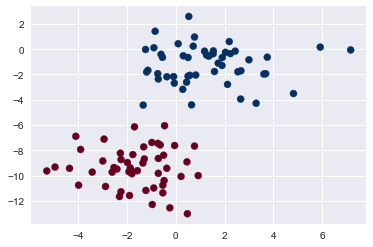

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

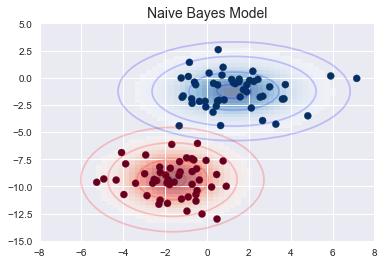

In [6]:
# 一种快速创建简易模型的方法就是假设数据服从高斯一样
# 且变量无协方差(指线性无关)只要找出每个标签的所有样本点
# 均值和标准差，再定义一个高斯分布，就可以拟合模型了。
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 60)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)
#fig.savefig('figures/05.05-gaussian-NB.png')

In [7]:
# 使用scikit-learn的评估器实现
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y)

GaussianNB(priors=None)

In [8]:
# 生成新的数据点
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

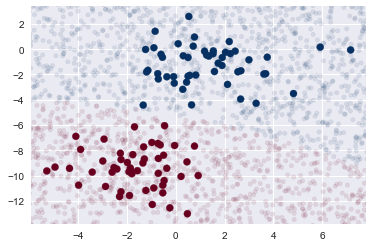

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

In [10]:
# 贝叶斯分类器通过计算每个类别的后验概率进行分类
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

### 5.5.3　多项式朴素贝叶斯
1. 案例：文本分类
多项式朴素贝叶斯通常用于文本分类，其特征都是指待分类文本的单词出现次数或者频
次。5.4 节介绍过文本特征提取的方法，这里用 20 个网络新闻组语料库（20 Newsgroups 
corpus，约 20 000 篇新闻）的单词出现次数作为特征，演示如何用多项式朴素贝叶斯对这
些新闻组进行分类.

In [11]:
# 获取数据
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [12]:
# 选择四类新闻
categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 
              'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



为了让这些数据能用于机器学习，需要将每个字符串的内容转换成数值向量。可以创建一
个管道，将 TF–IDF 向量化方法与多项式朴素贝叶斯分类器组合在一起：

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [15]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

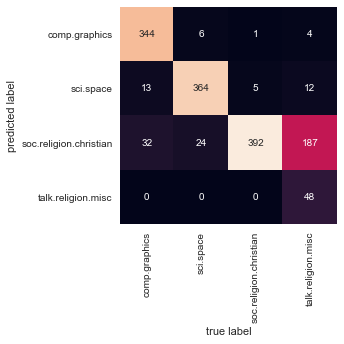

In [18]:
# 通过confusion矩阵统计测试数据的真实标签与预测标签的结果
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [19]:
def predict_category(s, train=train,model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [20]:
predict_category('sending a payload to the ISS')

'sci.space'

In [21]:
predict_category('discussing islam va atheism')

'soc.religion.christian'

In [22]:
predict_category('determining the screen resolution')

'comp.graphics'

In [23]:
predict_category('I am a computer engineer.')

'comp.graphics'